In [1]:
# importing matplotlib modules
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

import requests
from PIL import Image
from io import BytesIO


In [2]:
#@title Helper functions for loading image (hidden)

original_image_cache = {}

def preprocess_image(image):
  image = np.array(image)
  # reshape into shape [batch_size, height, width, num_channels]
  img_reshaped = tf.reshape(image, [1, image.shape[0], image.shape[1], image.shape[2]])
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  image = tf.image.convert_image_dtype(img_reshaped, tf.float32)
  return image

def load_image_from_url(img_url):
  """Returns an image with shape [1, height, width, num_channels]."""
  user_agent = {'User-agent': 'Colab Sample (https://tensorflow.org)'}
  response = requests.get(img_url, headers=user_agent)
  image = Image.open(BytesIO(response.content))
  image = preprocess_image(image)
  return image

In [3]:
def load_image(image_url, image_size=256, dynamic_size=False, max_dynamic_size=512):
  """Loads and preprocesses images."""
  # Cache image file locally.
  if image_url in original_image_cache:
    img = original_image_cache[image_url]
  elif image_url.startswith('https://'):
    img = load_image_from_url(image_url)
  else:
    fd = tf.io.gfile.GFile(image_url, 'rb')
    img = preprocess_image(Image.open(fd))
  original_image_cache[image_url] = img
  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img_raw = img
  if tf.reduce_max(img) > 1.0:
    img = img / 255.
  if len(img.shape) == 3:
    img = tf.stack([img, img, img], axis=-1)
  if not dynamic_size:
    img = tf.image.resize_with_pad(img, image_size, image_size)
  elif img.shape[1] > max_dynamic_size or img.shape[2] > max_dynamic_size:
    img = tf.image.resize_with_pad(img, max_dynamic_size, max_dynamic_size)
  return img, img_raw

In [4]:
def show_image(image, title=''):
  image_size = image.shape[1]
  #w = (image_size * 6) // 320
  w =10
  plt.figure(figsize=(w, w))
  plt.imshow(image[0], aspect='equal')
  plt.axis('off')
  plt.title(title)
  plt.show()

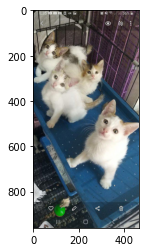

In [5]:
# Read Images

path = '../data/train/'

image_file = '00a1ae8867e0bb89f061679e1cf29e80.jpg'
img = mpimg.imread(path+image_file)
  
# Output Images
plt.imshow(img)

In [9]:
img.shape

(960, 467, 3)

In [11]:
img.max()

255

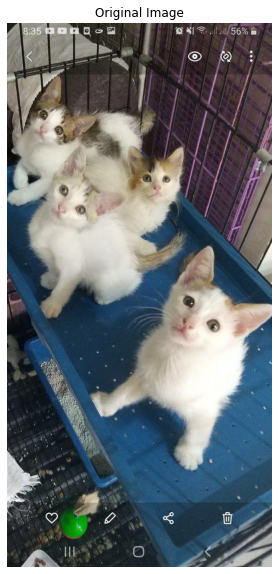

In [6]:
image_size = 224
dynamic_size = False
max_dynamic_size = 512

img_url = path+image_file
image, original_image = load_image(img_url, image_size, dynamic_size, max_dynamic_size)
show_image(original_image, 'Original Image')

In [29]:
original_image.shape

TensorShape([1, 960, 467, 3])

### PB Model Files for TensorFlow

pb stands for protobuf. In TensorFlow, the protbuf file contains the graph definition as well as the weights of the model. Thus, a pb file is all you need to be able to run a given trained model.

Given a pb file, you can load it as follow.

https://stackoverflow.com/questions/51278213/what-is-the-use-of-a-pb-file-in-tensorflow-and-how-does-it-work

In [11]:
def load_pb(path_to_pb):
    with tf.gfile.GFile(path_to_pb, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def, name='')
        return graph

In [12]:
path_to_pb = "../TF_models/mod1"
mod1 = load_pb(path_to_pb)
mod1

AttributeError: module 'tensorflow' has no attribute 'gfile'